# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

## Imports

In [ ]:
# cd  "C:\Users\sky66\Downloads\models\research" (cd to this folder)
# jupyter notebook

# conda install tensorflow=2.5.0=gpu_py39h7dc34a2_0
# conda uninstall tensorflow
# pip install "tensorflow==2.7.0"

# git clone --depth 1 https://github.com/tensorflow/models

# pip uninstall pyparsing -y
# pip install pyparsing==2.4.2

# pip uninstall pyyaml -y
# pip install pyyaml==5.1

# protoc object_detection/protos/*.proto --python_out=.
# python object_detection/packages/tf2/setup.py build
# python object_detection/packages/tf2/setup.py install

# conda list

# 參考資料
# https://www.jianshu.com/p/f8ffbf18c312
# https://stackoverflow.com/questions/68737130/error-while-import-keras-attributeerror-module-tensorflow-compat-v2-interna
# https://github.com/tensorflow/tensorflow/issues/53060
# https://medium.com/ching-i/win10-%E5%AE%89%E8%A3%9D-cuda-cudnn-%E6%95%99%E5%AD%B8-c617b3b76deb
# https://github.com/tensorflow/tensorflow/issues/52988

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf
import tensorflow.keras as keras

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Utilities

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Custom Image data

We will start with some toy (literally) data consisting of 6 images of two insect.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain some datas , so this is a novel class.

In [ ]:
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from IPython.display import display as ds
import shutil
import requests

In [4]:
path =  os.getcwd()
try:
  if(not os.path.exists(path+r"/images")):
     os.mkdir("images")
except:
  pass     

path=path.replace("\\", "/")

path=path+"/images/"

print( path )
path_v= os.getcwd()

C:/Users/sky66/Downloads/models/research/images/


In [5]:
trainImgUrl=[      'https://img.ruten.com.tw/s1/8/24/8b/21936662136971_938.jpg',
             'https://i1.jueshifan.com/205a28/7c067e8b/2f4d28804cfcfb59c228.jpg',
             'https://nature.goto307.com.tw/upload/animalia_m/6ee8ac5197618d18c94b0affc26faa97.jpg',
             'https://nature.goto307.com.tw/upload/animalia_m/6ee8ac5197618d18c94b0affc26faa97.jpg',
             'https://img.ruten.com.tw/s2/a/44/54/21918332657748_734.jpg',
             'http://bkc.prospect-bearing.com.tw/images/DSCN0660.JPG']

num_classes = 2



for i in trainImgUrl:
    try:
        my_save_url_img(i , path)
    except:
        pass

In [6]:
my_images_label=np.array([0,0,0,1,1] , dtype="int32")

In [7]:
trainImgUrl=[      'https://img.ruten.com.tw/s1/8/24/8b/21936662136971_938.jpg',
             'https://i1.jueshifan.com/205a28/7c067e8b/2f4d28804cfcfb59c228.jpg',
             'https://nature.goto307.com.tw/upload/animalia_m/6ee8ac5197618d18c94b0affc26faa97.jpg',
             'https://nature.goto307.com.tw/upload/animalia_m/6ee8ac5197618d18c94b0affc26faa97.jpg',
             'https://img.ruten.com.tw/s2/a/44/54/21918332657748_734.jpg',
             'http://bkc.prospect-bearing.com.tw/images/DSCN0660.JPG']
label_map= { 0: "Allomyrina dichotomus" , 1: "Lucanidae"}

In [8]:
def my_save_url_img(my_img_url,myPath): 
  headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36"}
  r = requests.get(my_img_url,headers=headers, stream=True)
  if r.status_code == 200:
    with open(str((myPath+my_img_url.split('/')[-1].split('?')[0])), 'wb') as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)

In [9]:
trainImgPath=[]

for i in trainImgUrl:
  trainImgPath.append(path+i.split('/')[-1].split('?')[0])

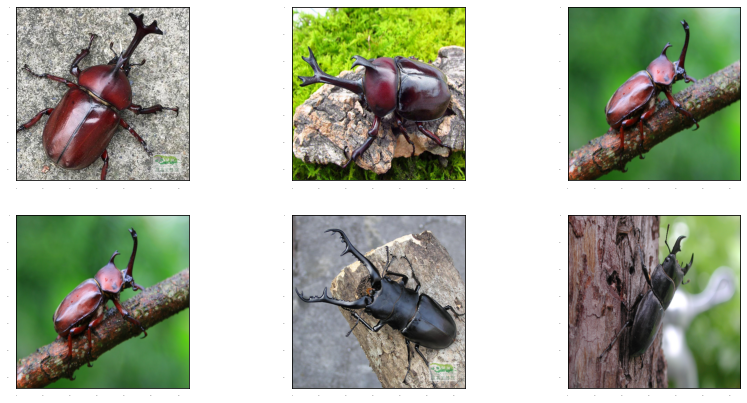

In [36]:
# Load images and visualize
train_images_np = []
plt_row ,plt_column= 2 ,3

#####if add image change it name and change range here

for i in range(0, len(trainImgPath)):
  image_path = trainImgPath[i]
  resImg=Image.open(image_path)
  resImg=resImg.resize((640,640))
  train_images_np.append(np.array(resImg))
  #train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):

  #####if add image change it name and change subplot row here  
  plt.subplot(plt_row, plt_column, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [11]:
print('trainImgUrl \n', trainImgUrl)
print('\n\n trainImgPath \n', trainImgPath)
print('\n\n my_images_label \n', my_images_label)
print('\n\n label_map \n', label_map)
print('\n\n train_images_np.shape \n', len(train_images_np),'\n' ,train_images_np[0].shape)

trainImgUrl 
 ['https://img.ruten.com.tw/s1/8/24/8b/21936662136971_938.jpg', 'https://i1.jueshifan.com/205a28/7c067e8b/2f4d28804cfcfb59c228.jpg', 'https://nature.goto307.com.tw/upload/animalia_m/6ee8ac5197618d18c94b0affc26faa97.jpg', 'https://nature.goto307.com.tw/upload/animalia_m/6ee8ac5197618d18c94b0affc26faa97.jpg', 'https://img.ruten.com.tw/s2/a/44/54/21918332657748_734.jpg', 'http://bkc.prospect-bearing.com.tw/images/DSCN0660.JPG']


 trainImgPath 
 ['C:/Users/sky66/Downloads/models/research/images/21936662136971_938.jpg', 'C:/Users/sky66/Downloads/models/research/images/2f4d28804cfcfb59c228.jpg', 'C:/Users/sky66/Downloads/models/research/images/6ee8ac5197618d18c94b0affc26faa97.jpg', 'C:/Users/sky66/Downloads/models/research/images/6ee8ac5197618d18c94b0affc26faa97.jpg', 'C:/Users/sky66/Downloads/models/research/images/21918332657748_734.jpg', 'C:/Users/sky66/Downloads/models/research/images/DSCN0660.JPG']


 my_images_label 
 [0 0 0 1 1]


 label_map 
 {0: 'Allomyrina dichotomus'

# Annotate images with bounding boxes




In [12]:
#ymin, xmin, ymax, xmax = tuple(boxes)

In [13]:
"""
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)
"""

'\ngt_boxes = []\ncolab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)\n'

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [14]:

gt_boxes=[np.array([[0.02606771, 0.0390625 , 0.97106771, 0.940625  ]]),
     np.array([[0.21106771, 0.0234375 , 0.93273438, 0.934375  ]]),
     np.array([[0.05940104, 0.2015625 , 0.91606771, 0.7734375 ]]),
     np.array([[0.21940104, 0.234375  , 0.80773438, 0.9765625 ]]),
     np.array([[0.06106771, 0.0140625 , 0.97106771, 0.971875  ]]),
     np.array([[0.03606771, 0.2171875 , 0.89273437, 0.7375    ]])]
   

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [15]:
print(type(train_images_np),"\n",len(train_images_np),"\n",type(train_images_np[0]),"\n",train_images_np[0].shape)

<class 'list'> 
 6 
 <class 'numpy.ndarray'> 
 (640, 640, 3)


In [38]:
train_images_np[1].shape

(640, 640, 3)

In [40]:
      tf.expand_dims(
          tf.convert_to_tensor(
              train_images_np[0], dtype=tf.float32 ) , axis=0).shape

TensorShape([1, 640, 640, 3])

In [51]:
zero_indexed_groundtruth_classes = tf.convert_to_tensor( my_images_label )

In [52]:
      tf.expand_dims(
          tf.one_hot(zero_indexed_groundtruth_classes, num_classes), axis=0)

<tf.Tensor: shape=(1, 4169, 2), dtype=float32, numpy=
array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)>

In [16]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.





# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np , my_images_label_np) in zip(
    train_images_np, gt_boxes , my_images_label):
  
  train_image_tensors.append(
      tf.expand_dims(
          tf.convert_to_tensor(
              train_image_np, dtype=tf.float32 ) , axis=0)
      )
  
  gt_box_tensors.append(
      tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  
  zero_indexed_groundtruth_classes = tf.convert_to_tensor( my_images_label_np )

  gt_classes_one_hot_tensors.append(
      tf.expand_dims(
          tf.one_hot(zero_indexed_groundtruth_classes, num_classes), axis=0)
  )
print('Done prepping data.')

Done prepping data.


In [17]:
print('\n gt_classes_one_hot_tensors[0] \n gt_box_tensors[0] \n train_image_tensors[0].shape\n\n')
print(gt_classes_one_hot_tensors[0])
print(gt_box_tensors[0])
print(train_image_tensors[0].shape)


 gt_classes_one_hot_tensors[0] 
 gt_box_tensors[0] 
 train_image_tensors[0].shape


tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.02606771 0.0390625  0.9710677  0.940625  ]], shape=(1, 4), dtype=float32)
(1, 640, 640, 3)


# Let's just visualize the rubber duckies as a sanity check


In [ ]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(
     image, 
     class_names, 
     boxes):
  ymin, xmin, ymax, xmax = tuple(boxes)
  colors = list(ImageColor.colormap.values())
  font_type = 'LiberationSansNarrow-Regular.ttf'
  font_size = 10
  #font = ImageFont.truetype(font_type,10 ,encoding='utf-8')
  font = ImageFont.load_default()
  display_str = (class_names)
  color = colors[hash(class_names) % len(colors)]
  image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
  draw_bounding_box_on_image(
        image_pil,
        ymin,
        xmin,
        ymax,
        xmax,
        color,
        font,
        display_str_list=[display_str])
  ds( Image.fromarray(np.uint8( np.array(image_pil) )).convert("RGB") )
  #return image

In [ ]:
train_images_np[0].shape

In [ ]:
Image.fromarray(np.uint8( train_images_np[0] )).convert("RGB")

In [ ]:
for i in range(0,len(trainImgPath)):
  draw_boxes(train_images_np[ i ], label_map[ my_images_label[i] ],  gt_boxes[ i ][0] )

In [ ]:
gt_boxes[0][0]

In [ ]:
"""
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index[0])
plt.show()
"""

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 33

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

In [24]:
all_keys = list(range(len(train_images_np)))
random.shuffle(all_keys)
example_keys = all_keys[:3]

# Note that we do not do data augmentation in this demo.  If you want a
# a fun exercise, we recommend experimenting with random horizontal flipping
# and random cropping :)
gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
image_tensors = [train_image_tensors[key] for key in example_keys]

In [25]:
all_keys

[2, 1, 3, 5, 0, 4]

In [26]:
example_keys

[2, 1, 3]

In [27]:
gt_boxes_list

[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.05940104, 0.2015625 , 0.9160677 , 0.7734375 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.2110677, 0.0234375, 0.9327344, 0.934375 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.21940105, 0.234375  , 0.8077344 , 0.9765625 ]], dtype=float32)>]

In [28]:
gt_classes_list

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>]

In [29]:
image_tensors

[<tf.Tensor: shape=(1, 640, 640, 3), dtype=float32, numpy=
 array([[[[ 62., 109.,  67.],
          [ 63., 110.,  67.],
          [ 63., 110.,  65.],
          ...,
          [158., 202., 187.],
          [158., 201., 185.],
          [158., 201., 184.]],
 
         [[ 61., 108.,  66.],
          [ 62., 109.,  66.],
          [ 63., 110.,  65.],
          ...,
          [156., 200., 184.],
          [158., 201., 185.],
          [159., 202., 185.]],
 
         [[ 61., 110.,  65.],
          [ 63., 110.,  66.],
          [ 64., 109.,  66.],
          ...,
          [159., 202., 185.],
          [158., 202., 185.],
          [157., 201., 184.]],
 
         ...,
 
         [[ 64.,  60.,  30.],
          [ 67.,  61.,  30.],
          [ 76.,  65.,  35.],
          ...,
          [ 72., 138.,  66.],
          [ 73., 139.,  67.],
          [ 74., 140.,  66.]],
 
         [[ 56.,  61.,  28.],
          [ 65.,  68.,  32.],
          [ 80.,  78.,  42.],
          ...,
          [ 73., 139.,  67.]

In [ ]:
import inspect
lines = inspect.getsource(train_step_fn)
print(lines)


# Load test images and run inference with new model!

In [ ]:
def draw_boxes_s(
     image, 
     class_names, 
     boxes,
     scores,
     score_limit):
  now_image_np=np.zeros((image.shape))
  np.copyto(now_image_np , image)

  for i in range(0,len(boxes)):
    if(float(scores[i])>score_limit):
      box , score , class_name = boxes[i] , scores[i] , class_names[i]
      class_name=label_map[class_name]
      ymin, xmin, ymax, xmax = tuple(box)
      colors = list(ImageColor.colormap.values())
    
      font = ImageFont.load_default()
      display_str = (class_name+":"+str(score))
      color = colors[hash(class_name) % len(colors)]

      image_pil = Image.fromarray(np.uint8(now_image_np)).convert("RGB")

      draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[display_str])
    
      np.copyto(now_image_np, np.array(image_pil) )

  ds(Image.fromarray(np.uint8( np.array(now_image_np) )).convert("RGB") )  
  #return image

In [ ]:
"""
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))
"""      

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function(input_signature=[tf.TensorSpec(shape=[None,640,640,3], dtype=tf.float32)])
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
"""
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")
"""      

In [ ]:
def img_to_tensor(img_np):
  img_tf = tf.convert_to_tensor(img_np, dtype=tf.float32 )
  img_tf = tf.expand_dims(img_tf, axis=0) 
  return img_tf 

def img_proccess(img):
  img = Image.open(img)

  detection_img = img.resize((640,640))
  detection_img = np.array(detection_img)

  img = np.array(img)
  origin_img = np.zeros(img.shape)

  np.copyto(origin_img ,img)

  detection_img = img_to_tensor(detection_img)

  return {'origin_img_np':origin_img , 'detection_img_tensor':detection_img}

In [ ]:
path_v = path_v+"/"

In [ ]:
test_img_url = "https://live.staticflickr.com/65535/49836236516_0f4a46ee04_b.jpg"
my_save_url_img(test_img_url, path_v)
path_test_img = path_v + test_img_url.split('?')[0].split('/')[-1]
path_test_img = img_proccess(path_test_img)

detections=detect( path_test_img["detection_img_tensor"] )

draw_boxes_s(
    path_test_img['origin_img_np'],
    detections['detection_classes'][0].numpy(),
    detections['detection_boxes'][0].numpy(),
    detections["detection_scores"][0].numpy(),
    0.3)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.saved_model.save(
    detection_model , path_v+'save_model',
    signatures={
      'detect': detect.get_concrete_function()
    })

In [ ]:
!mkdir save_model

In [ ]:
new_model=tf.saved_model.load(path_v+'save_model')

In [ ]:
new_model.signatures['detect']

In [ ]:
test_img_url = "https://live.staticflickr.com/65535/49836236516_0f4a46ee04_b.jpg"
my_save_url_img(test_img_url, path_v)
path_test_img = path_v + test_img_url.split('?')[0].split('/')[-1]
path_test_img = img_proccess(path_test_img)

detections= new_model.signatures['detect']( path_test_img["detection_img_tensor"] )

draw_boxes_s(
    path_test_img['origin_img_np'],
    detections['detection_classes'][0].numpy(),
    detections['detection_boxes'][0].numpy(),
    detections["detection_scores"][0].numpy(),
    0.3)

In [ ]:
"""
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))
"""